In [1]:
import os
import wandb
import copy 
import json

import pandas as pd 
print(pd.__version__)
import matplotlib.pyplot as plt
import numpy as np

import analyse_results_utils
from es_map import custom_configs
from es_map.my_brax_envs import brax_envs
# CUDA_VISIBLE_DEVICES=0 wandb agent adam_katona/uncategorized/noibtlha

1.4.2


In [22]:
api = wandb.Api()
jax_es_sweep = api.sweep("adam_katona/uncategorized/noibtlha") 
#jax_es_sweep = api.sweep("adam_katona/uncategorized/c7q2v97c") 
#jax_es_sweep = api.sweep("adam_katona/uncategorized/ghkaoset") 
#jax_es_sweep = api.sweep("adam_katona/uncategorized/jd18zi1o") 

sweep_runs = list(jax_es_sweep.runs)
len(sweep_runs)

194

In [23]:
def id_to_path(id):
    from glob import glob    
    path = glob("/scratch/ak1774/runs/large_files_jax/*"+id, recursive = False)[0]
    return path

In [24]:
#for i,wanddb_run in enumerate(sweep_runs):
#    print(i,wanddb_run.name,len(wanddb_run.history()))
#type(sweep_runs[27].config)
#plt.plot(sweep_runs[40].history()["generation_number"])
#sweep_runs[40].name

In [25]:
all_runs = []
failed_runs = []
for i,wanddb_run in enumerate(sweep_runs):
    if i%40 == 0:
        print(i,"/",len(sweep_runs))
    #run_logs = wanddb_run.history()
    
    config = copy.deepcopy(wanddb_run.config)
    config = custom_configs.get_config_from_index(config,config["config_index"])
    bd_descriptor = brax_envs.env_to_bd_descriptor(config["env_name"],config["env_mode"])
    config["map_elites_grid_description"] = bd_descriptor
    
    
    run_id = wanddb_run.dir.split("/")[-1]
    run = {}
    run["path"] = analyse_results_utils.id_to_path(run_id)
    if  os.path.exists(run["path"]+"/b_archive.npy"):
        run["b_map_evolver"] = np.load(run["path"]+"/b_map_evolver.npy",allow_pickle=True)
        run["b_map_performance"] = np.load(run["path"]+"/b_map_performance.npy",allow_pickle=True)
        run["b_archive"] = np.load(run["path"]+"/b_archive.npy")
        run["wandb_run"] = wanddb_run
        run["config"] = config
        all_runs.append(run)
    else:
        failed_runs.append(wanddb_run.config)

0 / 194
40 / 194
80 / 194
120 / 194
160 / 194


In [26]:
print("all_runs: ",len(all_runs))
print("failed_runs: ",len(failed_runs))

all_runs:  187
failed_runs:  7


In [27]:
def config_to_type(config):
    # the types i am interested in are:
    # if the ubdates are combined, we put a "_C" at the end
    acceptable_names = [
     "ME__explore",
     "ME__exploit",
     "ME__explore-exploit",
    
     "E-ME-f__exploit",
     "E-ME-f__explore-exploit",

     "E-ME-f__evolvability",
     "E-ME-f__evolvability-exploit",
     "E-ME-f__explore-evolvability-exploit",
    
     "E-ME-e__explore-evolvability-exploit",
     "E-ME-i__explore-evolvability-exploit",
    
     "MM-ME-fei__explore-evolvability-exploit",
     "ND-ME-fei__explore-evolvability-exploit",
    ]
    
    def in_mode(mode_list,mode):
        for m in mode_list:
            if mode in m:
                return True
        return False
    
    # first get the first part
    name = ""
    if config["BMAP_type_and_metrics"]["type"] == "single_map":
        if "eval_fitness" in config["BMAP_type_and_metrics"]["metrics"]:
            name += "ME__"
        else:
            name += "E-ME-"
            if "excpected_fitness" in config["BMAP_type_and_metrics"]["metrics"]:
                name += "f"
            if "evo_ent" in config["BMAP_type_and_metrics"]["metrics"] or "evo_var" in config["BMAP_type_and_metrics"]["metrics"]:
                name += "e"
            if "innovation" in config["BMAP_type_and_metrics"]["metrics"]:
                name += "i"
            name += "__"
    else:    
        if config["BMAP_type_and_metrics"]["type"] == "multi_map":
            name += "MM-ME-"
        elif config["BMAP_type_and_metrics"]["type"] == "nd_sorted_map":
            name += "ND-ME-"
            
        if "excpected_fitness" in config["BMAP_type_and_metrics"]["metrics"]:
            name += "f"
        if "evo_ent" in config["BMAP_type_and_metrics"]["metrics"] or "evo_var" in config["BMAP_type_and_metrics"]["metrics"]:
            name += "e"
        if "innovation" in config["BMAP_type_and_metrics"]["metrics"]:
            name += "i"
        name += "__"
        
    # now get the second part
    if in_mode(config["ES_UPDATES_MODES_TO_USE"],"innovation"):
        name += "explore-"
    if in_mode(config["ES_UPDATES_MODES_TO_USE"],"evo"):
        name += "evolvability-"
    if in_mode(config["ES_UPDATES_MODES_TO_USE"],"fitness"):
        name += "exploit-"
        
    # remove trailing dash
    if name[-1] == "-":
        name = name[:-1]
    
    return name
    #if name in acceptable_names:
    #    return name
    #else:
    #    return "not_interested"
    
    
def group_runs_by_type(runs):
    typed_runs = {}
    for run in runs:
        run_type = config_to_type(run["config"])
        run["ALGO_NAME"] = run_type
        if run_type != "not_interested":
            if run_type in typed_runs:
                typed_runs[run_type].append(run)
            else:
                typed_runs[run_type] = [run]
    return typed_runs
            
    
type_runs = group_runs_by_type(all_runs)


In [39]:
all_config_types = {}
for run in all_runs:
    all_config_types[run["config"]["config_index"]] = config_to_type(run["config"])
all_config_types


{0: 'ME__explore',
 11: 'E-ME-fei__explore-evolvability-exploit',
 10: 'E-ME-fei__explore-evolvability-exploit',
 9: 'E-ME-i__explore-evolvability-exploit',
 8: 'E-ME-e__explore-evolvability-exploit',
 7: 'E-ME-f__explore-evolvability-exploit',
 6: 'E-ME-f__evolvability-exploit',
 5: 'E-ME-f__evolvability',
 4: 'E-ME-f__explore-exploit',
 3: 'E-ME-f__exploit',
 2: 'ME__explore-exploit',
 1: 'ME__exploit'}

In [51]:
for run in all_runs: # [run for run in all_runs if run["config"]["config_index"]==11]:
    print(a["config"]["env_name"])
#    print(a["b_map_evolver"].shape)

walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker
walker

In [28]:
type_runs.keys()

dict_keys(['ME__explore', 'E-ME-fei__explore-evolvability-exploit', 'E-ME-i__explore-evolvability-exploit', 'E-ME-e__explore-evolvability-exploit', 'E-ME-f__explore-evolvability-exploit', 'E-ME-f__evolvability-exploit', 'E-ME-f__evolvability', 'E-ME-f__explore-exploit', 'E-ME-f__exploit', 'ME__explore-exploit', 'ME__exploit'])

In [29]:
all_runs[0].keys()

dict_keys(['path', 'b_map_evolver', 'b_map_performance', 'b_archive', 'wandb_run', 'config', 'ALGO_NAME'])

In [48]:
all_runs[0]["b_archive"].shape

(266, 2)

In [30]:
def add_colums_with_key(df,column_name,runs,lambda_fun):
    df[column_name] = [lambda_fun(run) for run in runs]

def get_non_empty_ratio(run):
    num_cells = run["b_map_performance"].size
    num_nonempty = sum((run["b_map_performance"] != None).reshape(-1))
    val = float(num_nonempty)/num_cells
    run["non_empty_ratio"] = val
    return val
    
def get_normal_qd_score(run):
    non_empty = run["b_map_performance"][run["b_map_performance"] != None]
    normal_fitnesses = [cell["elite"]["eval_normal_fitness"] for cell in non_empty]
    val = sum(normal_fitnesses)
    run["normal_qd_score"] = val
    return val


def get_distance_qd_score(run):
    non_empty = run["b_map_performance"][run["b_map_performance"] != None]
    normal_fitnesses = [cell["elite"]["eval_mean_dist"] for cell in non_empty]
    val = sum(normal_fitnesses)
    run["distance_qd_score"] = val
    return val

def get_best_normal_fitness(run):
    non_empty = run["b_map_performance"][run["b_map_performance"] != None]
    val = max([cell["elite"]["eval_normal_fitness"] for cell in non_empty])
    run["best_normal_fitness"] = val
    return val
    
def get_best_distance_fitness(run):
    non_empty = run["b_map_performance"][run["b_map_performance"] != None]
    val = max([cell["elite"]["eval_mean_dist"] for cell in non_empty])
    run["best_distance_fitness"] = val
    return val
    
import pandas as pd
df = pd.DataFrame()
add_colums_with_key(df,"ALGO_NAME",all_runs,lambda x : x["ALGO_NAME"])
add_colums_with_key(df,"env_name",all_runs,lambda x : x["config"]["env_name"])
add_colums_with_key(df,"env_mode",all_runs,lambda x : x["config"]["env_mode"])
#add_colums_with_key(df,"map_type",all_runs,lambda x : x["config"]["BMAP_type_and_metrics"]["type"])
#add_colums_with_key(df,"map_metrics",all_runs,lambda x : "".join(x["config"]["BMAP_type_and_metrics"]["metrics"]))
#add_colums_with_key(df,"updates",all_runs,lambda x : "".join(x["config"]["ES_UPDATES_MODES_TO_USE"]))

add_colums_with_key(df,"non_empty_ratio",all_runs,get_non_empty_ratio)
add_colums_with_key(df,"normal_qd_score",all_runs,get_normal_qd_score)
add_colums_with_key(df,"distance_qd_score",all_runs,get_distance_qd_score)
add_colums_with_key(df,"best_normal_fitness",all_runs,get_best_normal_fitness)
add_colums_with_key(df,"best_distance_fitness",all_runs,get_best_distance_fitness)

#df

In [31]:
def get_unique_combinations(runs,keys):
    all_tuples = []
    for run in runs:
        all_tuples.append(tuple(run["config"][key] for key in keys))
    return list(set(all_tuples))
combinations = get_unique_combinations(all_runs,["env_name","env_mode"])
combinations


[('halfcheetah', 'NORMAL_CONTACT'),
 ('hopper', 'NORMAL_CONTACT'),
 ('ant', 'NORMAL_CONTACT'),
 ('humanoid', 'CONTROL_FINAL_POS'),
 ('walker', 'NORMAL_CONTACT'),
 ('humanoid', 'DISTANCE_FINAL_POS'),
 ('hopper', 'CONTROL_FINAL_POS'),
 ('halfcheetah', 'CONTROL_FINAL_POS'),
 ('walker', 'CONTROL_FINAL_POS'),
 ('ant', 'CONTROL_FINAL_POS'),
 ('halfcheetah', 'DISTANCE_FINAL_POS'),
 ('humanoid', 'NORMAL_CONTACT'),
 ('ant', 'DISTANCE_FINAL_POS'),
 ('hopper', 'DISTANCE_FINAL_POS'),
 ('walker', 'DISTANCE_FINAL_POS')]

In [36]:
selected_combinations = [
    ('ant', 'NORMAL_CONTACT'),
    #('ant', 'DISTANCE_CONTACT'),
    ('ant', 'DISTANCE_FINAL_POS'),
    ('halfcheetah', 'NORMAL_CONTACT'),
    #('halfcheetah', 'DISTANCE_CONTACT'),
    ('halfcheetah', 'DISTANCE_FINAL_POS'),
]

In [34]:
custom_order = [
     "ME__explore",
     "ME__exploit",
     "ME__explore-exploit",
    
     "E-ME-f__exploit",
     "E-ME-f__explore-exploit",

     "E-ME-f__evolvability",
     "E-ME-f__evolvability-exploit",
     "E-ME-f__explore-evolvability-exploit",
    
     "E-ME-e__explore-evolvability-exploit",
     "E-ME-i__explore-evolvability-exploit",
    
     "MM-ME-fei__explore-evolvability-exploit",
     "ND-ME-fei__explore-evolvability-exploit",
    ]
def get_algo_index(algo):
    if algo in custom_order:
        return custom_order.index(algo)
    else:
        return 99999
df = df.sort_values(by="ALGO_NAME",key=lambda x: x.apply(get_algo_index))
df

,ALGO_NAME,env_name,env_mode,non_empty_ratio,normal_qd_score,distance_qd_score,best_normal_fitness,best_distance_fitness
0,ME__explore,walker,DISTANCE_FINAL_POS,0.040000,464.650382,6.083261,177.59874,1.8335097
184,ME__explore,walker,NORMAL_CONTACT,0.375977,18265.302567,258.377611,136.06114,1.1295115
183,ME__explore,hopper,NORMAL_CONTACT,0.530000,5295.866101,57.136595,180.45969,1.7908285
182,ME__explore,halfcheetah,NORMAL_CONTACT,0.295898,44752.192743,1661.579612,281.04156,12.000041
181,ME__explore,ant,DISTANCE_FINAL_POS,0.006836,-3400.432312,31.135876,-420.27896,5.801775
...,...,...,...,...,...,...,...,...
36,E-ME-fei__explore-evolvability-exploit,ant,NORMAL_CONTACT,0.023920,-1112.052752,52.770452,220.08266,3.1810937
14,E-ME-fei__explore-evolvability-exploit,walker,DISTANCE_FINAL_POS,0.040000,304.845474,5.589699,109.00961,1.4952008
15,E-ME-fei__explore-evolvability-exploit,humanoid,DISTANCE_FINAL_POS,0.003906,1491.916473,3.408246,409.21985,0.9203543
24,E-ME-fei__explore-evolvability-exploit,walker,CONTROL_FINAL_POS,0.030000,228.585953,1.538775,87.60625,1.0426825


('ant', 'NORMAL_CONTACT') 13


/scratch/ak1774/vargpu_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


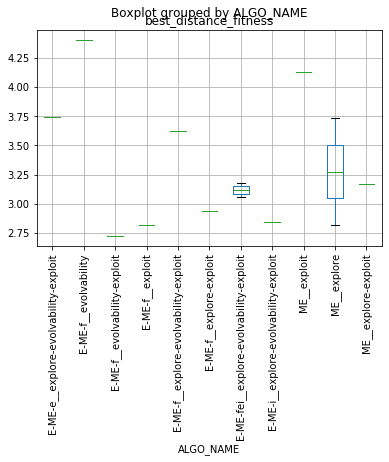

('ant', 'DISTANCE_FINAL_POS') 13


/scratch/ak1774/vargpu_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


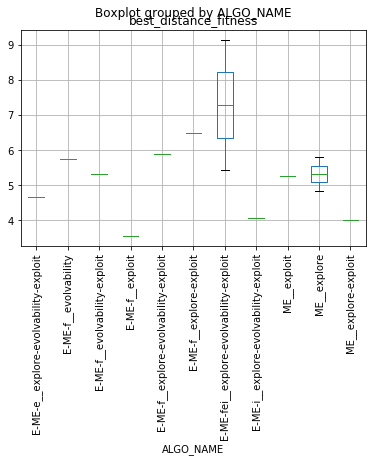

('halfcheetah', 'NORMAL_CONTACT') 12


/scratch/ak1774/vargpu_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


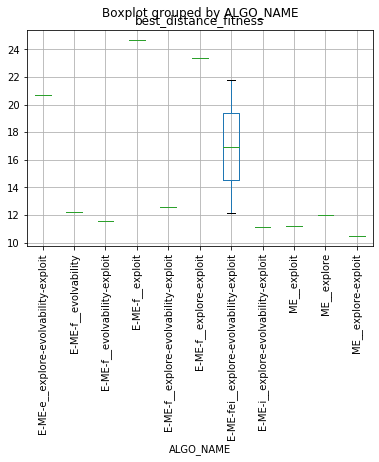

('halfcheetah', 'DISTANCE_FINAL_POS') 12


/scratch/ak1774/vargpu_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


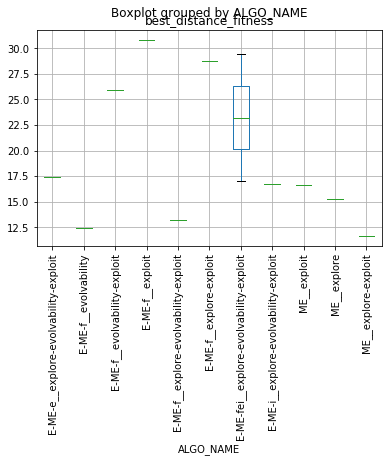

In [38]:
for env_combo in selected_combinations:
    mask = (df["env_name"] == env_combo[0]) & (df["env_mode"] == env_combo[1])
    print(env_combo,sum(mask))
    #display(df[mask])
    # normal_qd_score
    # best_distance_fitness
    # non_empty_ratio
    
    # now we want to group the runs with the same 
    #env_data = df[mask].groupby(by='ALGO_NAME')
    #env_data.boxplot(column='non_empty_ratio',rot=45) # by='ALGO_NAME'
    
    df[mask].boxplot(column='best_distance_fitness', by='ALGO_NAME',rot=90) 
    plt.show()

In [ ]:
# Go over all the hypothesis one by one
# Hipothesis 1, selecting for excpected fitness instead of eval fitness will help
# Hypothesis 2, adding evolvability update to the mix helps with everything
# Hypothesis 3, doing map insertion based on evolvability hepls
#  - sub question, is it better to do multi map or nd sorted map




In [35]:
for algo in set(df["ALGO_NAME"]):
    print(algo, sum(df["ALGO_NAME"] == algo) )


E-ME-i__explore-evolvability-exploit 10
E-ME-fei__explore-evolvability-exploit 17
E-ME-f__exploit 10
E-ME-e__explore-evolvability-exploit 10
E-ME-f__explore-evolvability-exploit 10
ME__explore-exploit 10
E-ME-f__evolvability 10
E-ME-f__evolvability-exploit 10
E-ME-f__explore-exploit 10
ME__exploit 10
ME__explore 10
